In [56]:
using Plots
using HDF5
using Unitful
using UnitfulRecipes
using Statistics
using Dates

# Load Filter output file

In [57]:
timestamp = "t0001" # Edit this value to plot a different time slice from the list above
field = "rain" # Choose from the fields listed above
output_folder = ""
unit_comp = 0.01#1000.0#1.0#0.01
level = 1

filename = joinpath(output_folder,"")
fh = h5open(filename, "r")

# println("The following datasets found in file ", filename, ": ", keys(fh))
# haskey(fh, "state_avg") && println("The following timestamps found: ", keys(fh["state_avg"]))
# haskey(fh["state_avg"], "t0001") && println("The following fields found: ", keys(fh["state_avg"]["t0001"]))

# field_unit = read(fh["state_avg"][timestamp][field]["Unit"])
field_unit = "hPa"
x_unit = read(fh["grid_coordinates"]["lon"]["Unit"])
y_unit = read(fh["grid_coordinates"]["lat"]["Unit"])
x_st_unit = read(fh["station_coordinates"]["lon"]["Unit"])
y_st_unit = read(fh["station_coordinates"]["lat"]["Unit"])

field_desc = read(fh["state_avg"][timestamp][field]["Description"])

x = read(fh["grid_coordinates"]["lon"]) .* uparse(x_unit) .|> u"°"
y = read(fh["grid_coordinates"]["lat"]) .* uparse(y_unit) .|> u"°"
z_avg = read(fh["state_avg"][timestamp][field]) .* uparse(field_unit)
x_st = read(fh["station_coordinates"]["lon"]) .* uparse(x_st_unit) .|> u"°"
y_st = read(fh["station_coordinates"]["lat"]) .* uparse(y_st_unit) .|> u"°"


500-element Vector{Quantity{Float64, NoDims, Unitful.FreeUnits{(°,), NoDims, nothing}}}:
                0.0°
                0.0°
                0.0°
  11.48936170212766°
  11.48936170212766°
  11.48936170212766°
  11.48936170212766°
  11.48936170212766°
  11.48936170212766°
  11.48936170212766°
                   ⋮
 168.51063829787236°
 168.51063829787236°
 168.51063829787236°
 168.51063829787236°
 168.51063829787236°
 168.51063829787236°
              180.0°
              180.0°
              180.0°

## Estimated Ensemble Size

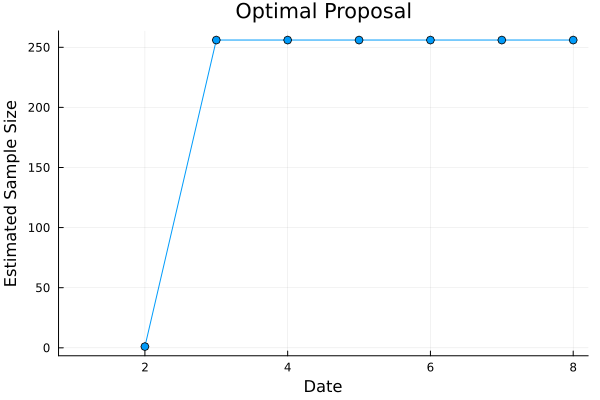

attempt to save state beyond implementation limit


In [60]:
IDate = "1982010100"
endDate = "1982080100"
SPEEDY_DATE_FORMAT = "YYYYmmddHH"
dates = collect(DateTime(IDate, SPEEDY_DATE_FORMAT):Dates.Hour(3):DateTime(endDate, SPEEDY_DATE_FORMAT))

plot(dates, [1 / sum(read(w) .^ 2) for w in fh["weights"]];
     label="", marker=:o, xlabel="Date", ylabel="Estimated Sample Size", title="Optimal Proposal")
Plots.savefig("Plots/ESS.png")

## Read in the Nature Run

In [61]:
filename = ""
th = h5open(filename, "r")

field_unit = "hPa"
field_desc = read(th["data_nature"][timestamp][field]["Description"]);
z_truth = read(th["data_nature"][timestamp][field]) .* uparse(field_unit);

In [49]:
using Plots.PlotMeasures
using GeoDatasets
function plot_error_std(x, y, z_t, z_avg, rmse, field_desc, date, timestamp, lon, lat, data)
    z_err = ((z_t-z_avg)./z_t).*100
    p1 = heatmap(x, y, transpose(z_avg); title="Assimilated Surface Pressure (μ)", annotations = (10, 10, Plots.text(string(date), :left)))
    p1 = Plots.contour!(lon,lat, (data.*100)', c = :blues)
    p2 = heatmap(x, y, transpose(z_err); title="% Error", colorbar_title="%", annotations = (10, 10, Plots.text(string(date), :left)))
    p2 = Plots.contour!(lon,lat, data', c = :blues)
    p3 = Plots.plot(rmse*unit_comp, label="", marker=:o, xlabel="Time step", ylabel="RMSE", title="RMSE of Surface Pressure over domain")
    p3 = vline!([timestamp], label=date)
    special_gauges = [47 12; 50 38; 14 41; 29 26; 3 44]
    for (i, plt) in enumerate((p1, p2, p3))
        # Set labels
        i ∈ (1) && Plots.plot!(plt; xlabel="Lon", ylabel="Lat", labelfontsize=20, tickfontsize=18)
        i ∈ (2) && Plots.plot!(plt; xlabel="Lon", labelfontsize=20, tickfontsize=18)
        # i ∈ (2) && Plots.plot!(plt; xlabel="Lon (°) ", labelfontsize=10)
        # i ∈ (3) && Plots.plot!(plt; xlabel="Timestep", ylabel="RMSE (hPa)", labelfontsize=10)
        # Set range of color bar for first two plots
        # i ∈ (1, 2) && plot!(plt; clims=(ustrip(zmin), ustrip(zmax)))
        # Add the positions of the stations
        i ∈ (1,2) && Plots.scatter!(plt, x_st, y_st, color=:black, marker=:star, label="Observation Locations")
        # i ∈ (1,2) && Plots.scatter!(plt, x_st[special_gauges[:,1]], y_st[special_gauges[:,2]], color=:red, marker=:star, label="Special Locations")

        # i ∈ (1,2) && Plots.contour!(lon,lat, data', c = :blues)
    end
    l = @layout[grid(1, 2)]
    Plots.plot(p1, p2, layout = l, titlefontsize=24, guidefontsize=20, colorbar_titlefontsize = 20, legendfontsize=12, legendtitlefontsize=12, left_margin = 40px, right_margin = 40px, bottom_margin = 40px)
    Plots.plot!(size=(1800,600))
    Plots.savefig("Plots/t_$timestamp.png")
end
lon,lat,data = GeoDatasets.landseamask(;resolution='c',grid=10)
coast = zeros(size(data))
coast[1:1080, 1:1080] .= data[1081:2160,1:1080]
coast[1081:2160,1:1080] .= data[1:1080, 1:1080]
lon = lon .+ 180
lat = lat .+ 90
x_plot = range(0,360,96)
y_plot = range(0,180,48)
for timestamp ∈ keys(fh["state_avg"]) 
    z_truth = read(th["data_nature"][timestamp][field]) .* uparse(field_unit)
    z_avg = read(fh["state_avg"][timestamp][field]) .* uparse(field_unit)
    number=parse(Int64,split(timestamp,'t')[2]);
    if number%100 == 0
        plot_error_std(x_plot, y_plot, z_truth[:,:,level]*unit_comp, z_avg[:,:,level]*unit_comp, rmse, field_desc, dates[number+1], number+1, lon, lat, coast)
    end
end

In [40]:
animation = @animate for timestamp ∈ keys(fh["state_avg"]) 
    z_truth = read(th["data_nature"][timestamp][field]) .* uparse(field_unit)
    z_avg = read(fh["state_avg"][timestamp][field]) .* uparse(field_unit)
    # number_as_string=split(timestamp)
    number=parse(Int64,split(timestamp,'t')[2]);
    idate = "1982010100";
    date = DateTime(idate, SPEEDY_DATE_FORMAT) + Dates.Hour(3*number);
    plot_error_std(x_plot, y_plot, z_truth[:,:,level]*unit_comp, z_avg[:,:,level]*unit_comp, rmse, field_desc, date, number, lon, lat, coast)
end
mp4(animation, joinpath(output_folder,string(field,".mp4")); fps=10)

InterruptException: InterruptException:

## Time Series of RMSE

In [64]:
rmse = Float64[].* uparse(field_unit)
for it = 0:length(keys(fh["state_avg"]))-1
    timestamp = "t" * lpad(string(it),4,'0')
    z_truth = read(th["data_nature"][timestamp][field]) .* uparse(field_unit)
    z_avg = read(fh["state_avg"][timestamp][field]) .* uparse(field_unit)
    error = sqrt.(mean((z_truth[:,:,level].-z_avg[:,:,level]).^2))
    push!(rmse, error)
end
# plot(rmse*unit_comp, label="", marker=:o, xlabel="Time step", ylabel="RMSE", title=string(field, "(level = ", level,")"))

In [ ]:
function plot_tdata(x, y, z_t, z_avg, z_std, field_desc)
    n_contours = 100
    zmax = max(maximum(z_t), maximum(z_avg))
    zmin = min(minimum(z_t), minimum(z_avg))
    levels = range(zmin, zmax; length=n_contours)
    z_err = z_t-z_avg
    p1 = heatmap(x, y, transpose(z_t); title="True $(lowercase(field_desc))")
    p2 = heatmap(x, y, transpose(z_avg); title="Assimilated $(lowercase(field_desc))")
    p3 = heatmap(x, y, transpose(z_std); title="Std of assimilated $(lowercase(field_desc))")
    p4 = heatmap(x, y, transpose(z_err); title="Error of $(lowercase(field_desc))")
    for (i, plt) in enumerate((p1, p2, p3, p4))
        # Set labels
        plot!(plt; xlabel="lon", ylabel="lat")
        # Set range of color bar for first two plots
        i ∈ (1, 2) && plot!(plt; clims=(ustrip(zmin), ustrip(zmax)))
        # Add the positions of the stations
        # scatter!(plt, x_st, y_st, color=:red, marker=:star, label="")
    end

    plot(p1, p2, p3, p4; titlefontsize=8, guidefontsize=8)
end
timestamp = "t0010"
level = 1
plot_tdata(x, y, z_truth[:,:,level]*unit_comp, z_avg[:,:,level]*unit_comp, z_avg[:,:,level]*unit_comp, field_desc)
# savefig("../results/speedy/testing/Obs.png")

In [ ]:
animation = @animate for timestamp ∈ keys(fh["state_avg"])
    z_truth = read(th["data_nature"][timestamp][field]) .* uparse(field_unit)
    z_avg = read(fh["state_avg"][timestamp][field]) .* uparse(field_unit)
    z_var = read(fh["data_var"][timestamp][field]) .* uparse(var_unit)
    z_std = sqrt.(z_var)

    plot_tdata(x, y, z_truth[:,:,level]*unit_comp, z_avg[:,:,level]*unit_comp, z_std[:,:,level]*unit_comp, field_desc)
end

mp4(animation, joinpath(output_folder,string(field,".mp4")); fps=2)

# Spatial RMSE

In [ ]:
error = zeros(96,48, length(keys(fh["state_avg"]))).* uparse(field_unit)
for it = 0:length(keys(fh["state_avg"]))-1
    timestamp = "t" * lpad(string(it),4,'0')
    z_truth = read(th["data_nature"][timestamp][field]) .* uparse(field_unit)
    z_avg = read(fh["state_avg"][timestamp][field]) .* uparse(field_unit)
    @view(error[:,:,it+1]) .= sqrt.((@view(z_truth[:,:,level]) - @view(z_avg[:,:,level])).^2)
end
error = error*unit_comp
rmse = mean(error, dims=3)


function plot_rmsedata(x, y, rmse, field_desc)
    n_contours = 100
    zmax = maximum(rmse)
    zmin = minimum(rmse)
    levels = range(zmin, zmax; length=n_contours)
    p1 = heatmap(x, y, transpose(rmse); title="Time Mean RMSE $(lowercase(field_desc))")
    plot!(p1; titlefontsize=8, guidefontsize=8)
    plot!(p1; xlabel="lon", ylabel="lat")
    plot!(p1; clims=(ustrip(zmin), ustrip(zmax)))

    # scatter!(p1, x_st, y_st, color=:red, marker=:star, label="")


    # plot(p1; titlefontsize=8, guidefontsize=8)
end

plot_rmsedata(x, y, rmse[:,:,1], field_desc)

# savefig(joinpath(output_folder,"Time-mean_RMSE.png"))